In [1]:
import pickle
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.manifold import TSNE

from utils import *


/opt/anaconda3/envs/ali_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataPath = "GenePT_emebdding_v2/GenePT_gene_embedding_ada_text.pickle"
# load data
with open(dataPath , "rb") as f:
    data_PT = pickle.load(f)

In [3]:
gene_names_all = list(data_PT.keys())

print("Number of all genes: ", len(gene_names_all))
# print 10 names
print("First 10 gene names: ", gene_names_all[:10])
# Get the embedding for the first gene
gene_name_eg = 'AATK' # gene_names[0]
embedding = np.array(data_PT[gene_name_eg])
print("Gene name: ", gene_name_eg)
print("Embedding size: ", embedding.shape[0])


Number of all genes:  93800
First 10 gene names:  ['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2ML1-AS1', 'A2MP1', 'A3GALT2', 'A4GALT']
Gene name:  AATK
Embedding size:  1536


In [4]:
data_path_sample = 'Data/PBMC/PBMC-ALL_ExpressionData.csv'
L = 10000 # number of cells to load (use None to load all cells)
if L is not None:
    data_sample = pd.read_csv(data_path_sample, header=0, index_col=0, usecols=range(L + 1)).T
else:
    data_sample = pd.read_csv(data_path_sample, header=0, index_col=0)
# data_sample = data_sample.transform(lambda x: np.log(x + 1))
print("Read data completed!")
# get number of genes and cells
num_cells_sample, num_genes_sample = data_sample.shape
print(f"Number of cells: {num_cells_sample}, Number of genes: {num_genes_sample}")
# get the name of the genes in the dataset
gene_names_sample = list(data_sample.columns)
# print("Name of the genes present in the sample ", gene_names_sample)


Read data completed!
Number of cells: 10000, Number of genes: 1000


In [5]:
# Function to get the present genes and their embeddings
# X_sample_PT: the gene embeddings from PT for the genes present in the sample
present_genes, X_sample_PT = get_present(gene_names_sample, gene_names_all, data_PT)

# load the true GRN:
data_path_true = 'Data/PBMC/PBMC-ALL_Imposed_GRN.csv'
ref_grn = load_edge_set(data_path_true)
ref_grn = set((g1, g2) for g1, g2 in ref_grn if g1 in present_genes and g2 in present_genes)
N = len(present_genes)
True_adj = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if i != j:
            True_adj[i,j] = 1 if (present_genes[i], present_genes[j]) in ref_grn else 0

Present genes found and embeddings shape: (802, 1536)


In [6]:
# get the expression of the present genes
present_expression = data_sample[present_genes].T.values
print("Node feature shape: ", present_expression.shape)
X_sample = np.array(present_expression)
print("X shape: ", X_sample.shape) # each row is the embedding of that gene
Corr_matrix = wgcna_grn(X_sample, beta=1)
# Corr_matrix = cosine_similarity(X_sample) # TODO
Corr_dist = 1 - Corr_matrix

Node feature shape:  (802, 10000)
X shape:  (802, 10000)


/opt/anaconda3/envs/ali_env/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/envs/ali_env/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [7]:
# Map X_sample_PT to X_sample to find the important features and do dimension reduction:

X_sample_NB = np.zeros((X_sample.shape[0], 7))  # Initialize an array for the features
for i in range(X_sample.shape[0]):
    if i % 100 == 0:
        print(f"Processing gene {i+1}/{X_sample.shape[0]}")
    X_sample_NB[i, :] = fit_nb_and_extract_features(X_sample[i, :])

print("Mapping PT features with shape:", X_sample_PT.shape , " to sample features with shape:", X_sample.shape)
LM = Ridge(alpha=1.0)
# LM = LinearRegression()
# LM = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
LM.fit(X_sample_PT, X_sample)
selector = SelectFromModel(LM, prefit=True, threshold='mean')
X_reduced_PT = selector.transform(X_sample_PT)
print("After model fitting: ", X_reduced_PT.shape)

# apply PCA to reduce the dimension 
scaler = StandardScaler()
X_reduced_PT = scaler.fit_transform(X_reduced_PT)
pca = PCA(n_components=100, random_state=42, whiten=False)
X_reduced_PT = pca.fit_transform(X_reduced_PT)

print("Reduced feature shape: ", X_reduced_PT.shape)

Processing gene 1/802
Processing gene 101/802
Processing gene 201/802
Processing gene 301/802
Processing gene 401/802
Processing gene 501/802
Processing gene 601/802
Processing gene 701/802
Processing gene 801/802
Mapping PT features with shape: (802, 1536)  to sample features with shape: (802, 10000)
After model fitting:  (802, 612)
Reduced feature shape:  (802, 100)


In [8]:
# Get upper triangle indices (excluding diagonal)
triu_indices = np.triu_indices(N, k=1)

# Prepare edge features and labels
edge_features_PT = []
edge_features_reduced = []
edge_labels = []

for i, j in zip(*triu_indices):
    label = True_adj[i, j]
    edge_labels.append(label)
    # Feature: average or concatenate of the two nodes' features
    feat_i = X_reduced_PT[i]
    feat_j = X_reduced_PT[j]
    # You can also try np.abs(feat_i - feat_j) or np.concatenate([feat_i, feat_j])
    edge_feat = (feat_i + feat_j)/2
    edge_features_reduced.append(edge_feat)

    feat_i = X_sample_PT[i]
    feat_j = X_sample_PT[j]
    edge_feat_PT = (feat_i + feat_j)/2
    edge_features_PT.append(edge_feat_PT)
    
    

edge_features_PT = np.array(edge_features_PT)
edge_features_reduced = np.array(edge_features_reduced)
edge_labels = np.array(edge_labels)

# Whole features:
clf = LogisticRegression(max_iter=1000)
# clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
clf.fit(edge_features_PT, edge_labels)
# Evaluation
y_pred_prob = clf.predict_proba(edge_features_PT)[:, 1]
y_pred = clf.predict(edge_features_PT)

print("Using whole PT features concatenation to predict the true edges.")
print("Edge features shape:", edge_features_PT.shape)
print("Accuracy:", accuracy_score(edge_labels, y_pred))
print("ROC AUC:", roc_auc_score(edge_labels, y_pred_prob))
print("Confusion matrix:\n", confusion_matrix(edge_labels, y_pred), "F1 Score: ", np.round(100*f1_score(edge_labels, y_pred),2))

# Reduced features:
clf_reduced = LogisticRegression(max_iter=1000)
# clf_reduced = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
clf_reduced.fit(edge_features_reduced, edge_labels)
# Evaluation
y_pred_prob_reduced = clf_reduced.predict_proba(edge_features_reduced)[:, 1]
y_pred_reduced = clf_reduced.predict(edge_features_reduced)

print("Using reduced PT features concatenation to predict the true edges.")
print("Edge features shape:", edge_features_reduced.shape)
print("Accuracy:", accuracy_score(edge_labels, y_pred_reduced))
print("ROC AUC:", roc_auc_score(edge_labels, y_pred_prob_reduced))
print("Confusion matrix:\n", confusion_matrix(edge_labels, y_pred_reduced), "F1 Score: ", np.round(100*f1_score(edge_labels, y_pred_reduced),2))



Using reduced PT features concatenation to predict the true edges.
Edge features shape: (321201, 100)
Accuracy: 0.9655480524655901
ROC AUC: 0.9342658622952578
Confusion matrix:
 [[308140   1976]
 [  9090   1995]] F1 Score:  26.5


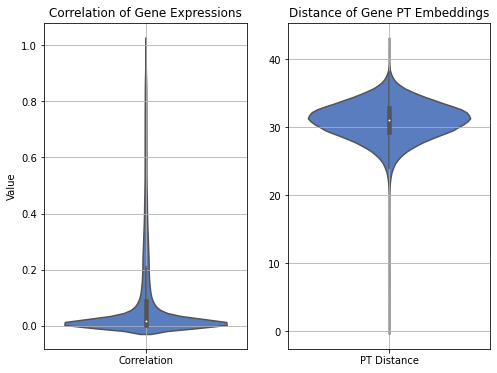

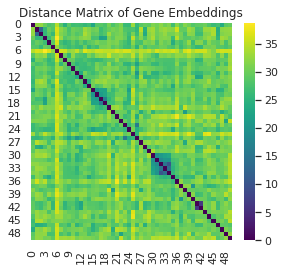

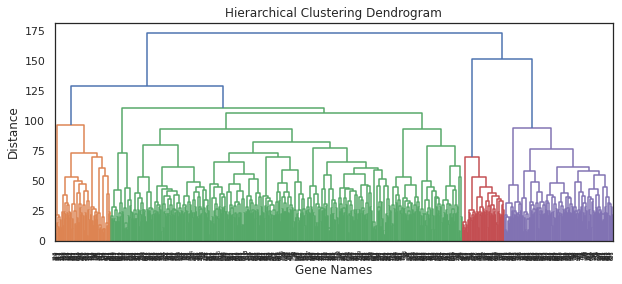

In [9]:
# Compute the distance matrix
# L-2 norm dist:
D_PT = np.linalg.norm(X_reduced_PT[:, np.newaxis] - X_reduced_PT, axis=2, ord=2)
# cosine:
# cosine_sim_matrix = cosine_similarity(X_reduced_PT)
# D_PT = 1 - cosine_sim_matrix
np.fill_diagonal(D_PT, 0)
D_PT[D_PT < 0] = 0



# get the violin plot for the distance and correlation
corr_values = Corr_matrix[np.triu_indices(N, k=1)]
dist_values = D_PT[np.triu_indices(N, k=1)]

plt.figure(figsize=(8, 6), facecolor='white')
plt.subplot(1, 2, 1)
sns.violinplot(data=[corr_values], palette='muted')
plt.xticks([0], ['Correlation'])
plt.ylabel('Value')
plt.grid()
plt.title('Correlation of Gene Expressions')
plt.subplot(1, 2, 2)
sns.violinplot(data=[dist_values], palette='muted')
plt.xticks([0], ['PT Distance'])
# plt.ylabel('Value')
plt.grid()
plt.title('Distance of Gene PT Embeddings')
plt.show()


# Plot the distance matrix
sns.set(style='white')
plt.figure(figsize=(4.5, 4), facecolor='white')
sns.heatmap(D_PT[:50,:50], cmap='viridis') # xticklabels=gene_names_subset, yticklabels=gene_names_subset,
plt.title('Distance Matrix of Gene Embeddings')
plt.show()

# apply heirarchical clustering to the distance matrix
linkage_matrix = linkage(squareform(D_PT), method='ward')
plt.figure(figsize=(10, 4), facecolor='white')
dendrogram(linkage_matrix, leaf_rotation=90, color_threshold=None)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Gene Names')
plt.ylabel('Distance')
plt.show()



In [10]:
# Get the binary adjacency matrix from the correlation distance matrix
A_corr = get_adjacency_matrix(Corr_dist, threshold=None)
A_PT = get_adjacency_matrix(D_PT, threshold=None)
# plot_graph(A_PT[:50,:50], present_genes[:50])

# compare Adjacency matrix with correlation matrix numerically
NN2 = (N * (N - 1) / 2)
A_PT_flat = A_PT.flatten()
A_corr_flat = A_corr.flatten()
num_edges_PT = np.sum(A_PT_flat > 0) / 2
num_edges_corr = np.sum(A_corr_flat > 0) / 2
print("Edge density in PT adjacency matrix: ", num_edges_PT / NN2)
print("Edge density in correlation matrix: ", num_edges_corr / NN2)
shared_edges = np.sum((A_PT_flat > 0) & (A_corr_flat > 0)) / 2
print("Number of edges in PT adjacency matrix: ", num_edges_PT)
print("Number of edges in correlation matrix: ", num_edges_corr)
print("Number of shared edges: ", shared_edges)


# save correlation matrix
i_corr, j_corr = np.triu_indices_from(A_corr, k=1)
nonzero_mask_corr = A_corr[i_corr, j_corr] != 0
i_corr = i_corr[nonzero_mask_corr]
j_corr = j_corr[nonzero_mask_corr]
edges_corr = [(present_genes[src], present_genes[tgt]) for src, tgt in zip(i_corr, j_corr)]
edges_corr_df = pd.DataFrame(edges_corr, columns=['Gene1', 'Gene2'])
edges_corr_df.to_csv('Data/PBMC/Corr_edges.csv', index=False)

# save PT matrix
i_PT, j_PT = np.triu_indices_from(A_PT, k=1)
nonzero_mask_PT = A_PT[i_PT, j_PT] != 0
i_PT = i_PT[nonzero_mask_PT]
j_PT = j_PT[nonzero_mask_PT]
edges_PT = [(present_genes[src], present_genes[tgt]) for src, tgt in zip(i_PT, j_PT)]
edges_PT_df = pd.DataFrame(edges_PT, columns=['Gene1', 'Gene2'])
edges_PT_df.to_csv('Data/PBMC/PT_edges.csv', index=False)

# load the graphs to compare
corr_grn = load_edge_set('Data/PBMC/Corr_edges.csv')
pt_grn = load_edge_set('Data/PBMC/PT_edges.csv')
grns = [ref_grn, corr_grn, pt_grn]
jaccard_results = pd.DataFrame(index=['Ref', 'Corr', 'PT'], columns=['Ref', 'Corr', 'PT'])
# Fill the DataFrame with Jaccard indices
for i, grn1 in enumerate(grns):
    for j, grn2 in enumerate(grns):
        jaccard_results.iloc[i, j] = np.round(100*jaccard_index(grn1, grn2),2)

print("Jaccard Index Results:")
print(jaccard_results)


all_genes = set()
for u, v in ref_grn:
    all_genes.add(u)
    all_genes.add(v)

# Compute confusion matrices
cm_corr, f1_corr = compute_confusion_matrix(corr_grn, ref_grn, all_genes)
cm_pt, f1_pt = compute_confusion_matrix(pt_grn, ref_grn, all_genes)

# display the confusion matrices for the two networks
print("Confusion Matrix for Correlation Network:")
print(cm_corr, "F1 Score: ", f1_corr)

print("Confusion Matrix for PT Network:")
print(cm_pt, "F1 Score: ", f1_pt)

Edge density in PT adjacency matrix:  0.47489578176904806
Edge density in correlation matrix:  0.23676451816775165
Number of edges in PT adjacency matrix:  152537.0
Number of edges in correlation matrix:  76049.0
Number of shared edges:  38505.0
Jaccard Index Results:
        Ref   Corr     PT
Ref   100.0   1.93   3.85
Corr   1.93  100.0  20.26
PT     3.85  20.26  100.0
Confusion Matrix for Correlation Network:
[[235720  74396]
 [  9432   1653]] F1 Score:  3.794156127344091
Confusion Matrix for PT Network:
[[163638 146478]
 [  5026   6059]] F1 Score:  7.406094534964736


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert numpy adjacency matrix to sparse format
A_PT_sparse = sp.csr_matrix(A_PT)
edge_index_PT, _ = from_scipy_sparse_matrix(A_PT_sparse)

A_corr_sparse = sp.csr_matrix(A_corr)
edge_index_corr, _ = from_scipy_sparse_matrix(A_corr_sparse)

A_true_sparse = sp.csr_matrix(True_adj)
edge_index_true, _ = from_scipy_sparse_matrix(A_true_sparse)

num_nodes = A_PT.shape[0]
# Choose the initial embeddings:
# x = torch.randn((num_nodes, 32)) # random guassian features
# x = torch.Tensor(X_sample_NB) # gene expression features
x = torch.Tensor(X_reduced_PT) # genePT embeddings

# Create PyG data object
data = Data(x=x, edge_index=edge_index_corr).to(device)

# Target adjacency matrix for the training
adj_target = torch.FloatTensor(True_adj).to(device)

In [12]:
model = GraphAutoEncoder(in_channels=data.x.shape[1], hidden_channels_list=[256], out_channels=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

model.train()
loss_min = 10e9
epoch_min = 0
for epoch in range(0, 5001):
    optimizer.zero_grad()
    adj_pred = model(data.x, data.edge_index)
    loss = adj_bce_loss(adj_pred, adj_target, mask=None) # None: loss is calculated on the whole upper triangle of the adjacency matrix
    if loss.item() < loss_min:
        loss_min = loss.item()
        epoch_min = epoch
        torch.save(model.state_dict(), 'Data/PBMC/model.pt')
    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Best Loss: {loss_min:.4f}, Best Epoch: {epoch_min}")


Epoch 0, Loss: 0.6753, Best Loss: 0.6753, Best Epoch: 0
Epoch 500, Loss: 0.1003, Best Loss: 0.0783, Best Epoch: 465
Epoch 1000, Loss: 0.0694, Best Loss: 0.0577, Best Epoch: 913
Epoch 1500, Loss: 0.0530, Best Loss: 0.0486, Best Epoch: 1440
Epoch 2000, Loss: 0.0502, Best Loss: 0.0429, Best Epoch: 1662
Epoch 2500, Loss: 0.0424, Best Loss: 0.0422, Best Epoch: 2499
Epoch 3000, Loss: 0.0406, Best Loss: 0.0392, Best Epoch: 2969
Epoch 3500, Loss: 3.4511, Best Loss: 0.0374, Best Epoch: 3125
Epoch 4000, Loss: 3.4511, Best Loss: 0.0374, Best Epoch: 3125
Epoch 4500, Loss: 3.4511, Best Loss: 0.0374, Best Epoch: 3125
Epoch 5000, Loss: 3.4511, Best Loss: 0.0374, Best Epoch: 3125


Best threshold (ROC): 0.05
Best threshold (PR): 0.34


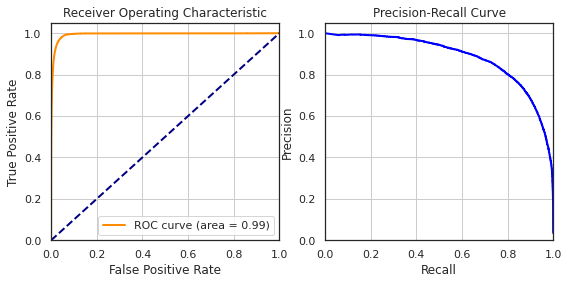

ROC AUC: 99.39
Precision: 78.25, Recall: 82.53, F1: 80.33
Confusion Matrix:
[[307573   2543]
 [  1937   9148]]


In [13]:
# load the saved model
model.load_state_dict(torch.load('Data/PBMC/model.pt'))
model.eval()
with torch.no_grad():
    adj_pred_eval = model(data.x, data.edge_index) 

# Remove self-loops (diagonal)
adj_pred_eval = adj_pred_eval * (1 - torch.eye(adj_pred_eval.size(0)).to(adj_pred_eval.device))

# Use the upper triangle indices (excluding diagonal)
N = adj_pred_eval.shape[0]
triu_indices = torch.triu_indices(N, N, offset=1)
adj_pred_eval[triu_indices[1], triu_indices[0]] = adj_pred_eval[triu_indices[0], triu_indices[1]]


# Flatten only the upper triangle
adj_true_flat = adj_target[triu_indices[0], triu_indices[1]]
adj_pred_flat = adj_pred_eval[triu_indices[0], triu_indices[1]]




# plot the ROC curve
fpr, tpr, thresholds_pred = roc_curve(adj_true_flat.cpu().numpy(), adj_pred_flat.cpu().numpy())
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(9, 4), facecolor='white')
plt.subplot(1,2,1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# get the best threshold from the fpr, tpr, thresholds_pred
best_threshold_roc = thresholds_pred[np.argmax(tpr - fpr)]
print(f"Best threshold (ROC): {best_threshold_roc:.2f}")


# plot the recall-precision curve
precision, recall, thresholds_pred = precision_recall_curve(adj_true_flat.cpu().numpy(), adj_pred_flat.cpu().numpy())
plt.subplot(1,2,2)
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
# get the best threshold from the precision, recall, thresholds_pred
best_threshold_pr = thresholds_pred[np.argmax(precision + recall)]
print(f"Best threshold (PR): {best_threshold_pr:.2f}")

plt.show()


# Threshold to get binary adjacency
threshold = best_threshold_pr if best_threshold_pr > 0.1 else 0.50
adj_pred_eval_binary = (adj_pred_eval > threshold).float()
adj_pred_binary_flat = adj_pred_eval_binary[triu_indices[0], triu_indices[1]]
infered_grn = adj_pred_eval_binary

# Compute metrics
roc_auc = roc_auc_score(adj_true_flat.cpu().numpy(), adj_pred_flat.cpu().numpy())
f1 = f1_score(adj_true_flat.cpu().numpy(), adj_pred_binary_flat.cpu().numpy())
precision = precision_score(adj_true_flat.cpu().numpy(), adj_pred_binary_flat.cpu().numpy())
recall = recall_score(adj_true_flat.cpu().numpy(), adj_pred_binary_flat.cpu().numpy())
confusion = confusion_matrix(adj_true_flat.cpu().numpy(), adj_pred_binary_flat.cpu().numpy())

# Print results
print(f"ROC AUC: {roc_auc*100:.2f}")
print(f"Precision: {precision*100:.2f}, Recall: {recall*100:.2f}, F1: {f1*100:.2f}")
print("Confusion Matrix:")
print(confusion)

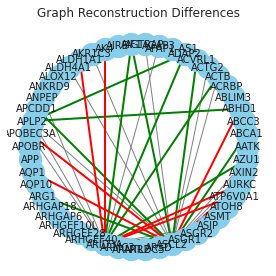

In [14]:
# plot the added and removed edges of the correlation graph:
plot_diff_graph(adj_original=adj_target[:50,:50].cpu().numpy(),
                adj_reconstructed=infered_grn[:50,:50].cpu().numpy(),
                node_labels=present_genes[:50],)

In [15]:
# Save the inferred GRN to a CSV file


infered_grn = adj_pred_eval_binary
infered_grn = infered_grn.cpu().numpy()
i, j = np.triu_indices_from(infered_grn, k=1)
nonzero_mask = infered_grn[i, j] != 0
i = i[nonzero_mask]
j = j[nonzero_mask]

# Create edge list with gene names
edges = [(present_genes[src], present_genes[tgt]) for src, tgt in zip(i, j)]

# Save to CSV
edges_df = pd.DataFrame(edges, columns=['Gene1', 'Gene2'])
edges_df.to_csv('Data/PBMC/GnnPT_edges.csv', index=False)

Jaccard Index Results:
        Ref   Corr     PT    Our
Ref   100.0   1.93   3.85  67.13
Corr   1.93  100.0  20.26   1.73
PT     3.85  20.26  100.0   4.09
Our   67.13   1.73   4.09  100.0


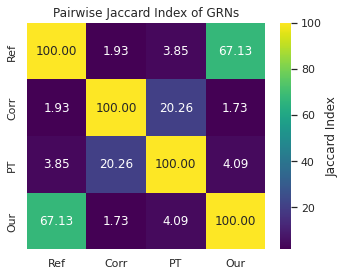

In [16]:
# Load the three GRNs with the true GRN to compare them:

our_grn = load_edge_set('Data/PBMC/GnnPT_edges.csv')

# List of all GRNs
grns = [ref_grn, corr_grn, pt_grn, our_grn]



# Create a DataFrame to store the results
jaccard_results = pd.DataFrame(index=['Ref', 'Corr', 'PT', 'Our'], columns=['Ref', 'Corr', 'PT', 'Our'])
# Fill the DataFrame with Jaccard indices
for i, grn1 in enumerate(grns):
    for j, grn2 in enumerate(grns):
        jaccard_results.iloc[i, j] = np.round(100*jaccard_index(grn1, grn2),2)

print("Jaccard Index Results:")
print(jaccard_results)

# plot the Jaccard Index results as a heatmap
plt.figure(figsize=(5, 4), facecolor='white')
sns.heatmap(jaccard_results.astype(float), annot=True, cmap='viridis', fmt=".2f", cbar_kws={'label': 'Jaccard Index'})
plt.title('Pairwise Jaccard Index of GRNs')
# plt.xlabel('GRN 1')
# plt.ylabel('GRN 2')
# plt.xticks(rotation=45)
# plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('Plots/PBMC.jpg', dpi=300)
plt.show()


In [17]:
# Get the set of all genes in the reference GRN
all_genes = set()
for u, v in ref_grn:
    all_genes.add(u)
    all_genes.add(v)

# Compute confusion matrices
cm_corr, f1_corr = compute_confusion_matrix(corr_grn, ref_grn, all_genes)
cm_pt, f1_pt = compute_confusion_matrix(pt_grn, ref_grn, all_genes)
cm_our, f1_our = compute_confusion_matrix(our_grn, ref_grn, all_genes)

# display the confusion matrices for the two networks
print("Confusion Matrix for Correlation Network:")
print(cm_corr, "F1 Score: ", f1_corr)

print("Confusion Matrix for PT Network:")
print(cm_pt, "F1 Score: ", f1_pt)

print("Confusion Matrix for GNN Network:")
print(cm_our, "F1 Score: ", f1_our)

Confusion Matrix for Correlation Network:
[[235720  74396]
 [  9432   1653]] F1 Score:  3.794156127344091
Confusion Matrix for PT Network:
[[163638 146478]
 [  5026   6059]] F1 Score:  7.406094534964736
Confusion Matrix for GNN Network:
[[307573   2543]
 [  1937   9148]] F1 Score:  80.33017211099403


In [18]:
# check the correlation and PT distance compared to the true adjacency matrix
Feature1 = D_PT[triu_indices[0], triu_indices[1]]
Feature2 = Corr_matrix[triu_indices[0], triu_indices[1]]
True_labels = True_adj[triu_indices[0], triu_indices[1]]

Logistic Regression Coefficients:
PTDist Coefficient: -0.0520, Corr Coefficient: -2.0109
Logistic Regression Accuracy: 96.55
Confusion Matrix for Logistic Regression:
[[310116      0]
 [ 11085      0]]


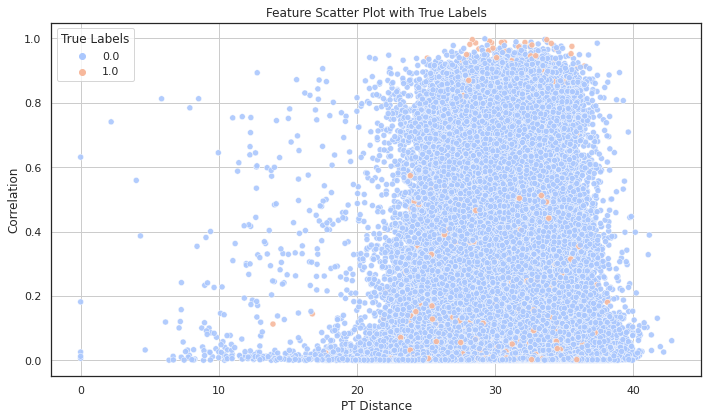

In [19]:
# check how well we can predict the true labels using the two features
from sklearn.linear_model import LogisticRegression
# Combine features into a DataFrame
features_df = pd.DataFrame({
    'PTDist': Feature1,
    'Corr': Feature2,
    'True_labels': True_labels
})


# Split into features and target
X = features_df[['PTDist', 'Corr']]
y = features_df['True_labels']
# Train a logistic regression model
model_lr = LogisticRegression()
model_lr.fit(X, y)
# Get the coefficients
coefficients = model_lr.coef_[0]
print("Logistic Regression Coefficients:")
print(f"PTDist Coefficient: {coefficients[0]:.4f}, Corr Coefficient: {coefficients[1]:.4f}")
# Get the accuracy of the model
accuracy = model_lr.score(X, y)
print(f"Logistic Regression Accuracy: {100*accuracy:.2f}")
# get the confusion matrix
y_pred = model_lr.predict(X)
cm_lr = confusion_matrix(y, y_pred)
print("Confusion Matrix for Logistic Regression:")
print(cm_lr)

# Melt the DataFrame to long format
melted_df = X.melt(var_name='Feature', value_name='Value')

# Plot the violin plot
plt.figure(figsize=(10, 6), facecolor='white')
# plt.subplot(1, 2, 1)
# sns.violinplot(x='Feature', y='Value', data=melted_df)
# plt.title('Violin Plot of Each Feature')
# plt.xlabel('Feature')
# plt.ylabel('Value')
# plt.grid()
# plot the features with the true labels
# plt.subplot(1, 2, 2)
sns.scatterplot(x=Feature1, y=Feature2, hue=True_labels, palette='coolwarm', alpha=0.9)
plt.title('Feature Scatter Plot with True Labels')
plt.xlabel('PT Distance')
plt.ylabel('Correlation')
plt.legend(title='True Labels', loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()


